In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

from nexuskan import *
from nexuskan import KAN
from nexuskan import nexusKAN

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Dataset** $y = x_0 x_1$ and orig. KAN multiplicaton

In [4]:
end_range = 1.0
start_range = 0.5
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range
# y = torch.sin(2 * torch.pi * x[:, 0]) + torch.sin(2 * torch.pi * x[:, 1])
y = x[:, 0] * x[:, 1]
# y_class = torch.where(y > 0.5, 1.0, 0.0)
dataset = {
    'train_input': x[:1000],
    'train_label': y[:1000],
    # 'train_label': y_class[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    'test_label': y[-200:],
    # 'test_label': y_class[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [5]:
model = KAN(width=[2, [1, 1], 1], grid=5, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


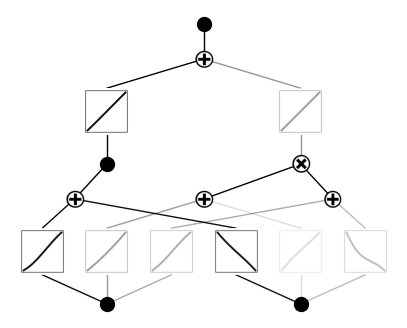

In [6]:
model(dataset['train_input'])
model.plot()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

batch_size = 512 # dataset['train_input'].shape[0]
epochs = 600

for epoch in range(epochs):
    batches = dataset['train_input'].shape[0] // batch_size
    for batch_idx in range(batches):
        if batch_idx == batches - 1:
            indices = torch.arange(batch_idx * batch_size, dataset['train_input'].shape[0])
        else:
            indices = torch.arange(batch_idx * batch_size, (batch_idx + 1) * batch_size)
    
        batch_x = dataset['train_input'][indices]
        batch_y = dataset['train_label'][indices]
        
        outputs = model(batch_x)
        
        train_loss = criterion(outputs, batch_y)
        
        # reg = 0.0
        lamb = 0.0001
        l1_reg = sum(torch.norm(p, 1) for p in model.parameters())
        loss = train_loss + lamb * l1_reg
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step(),
    
    with torch.no_grad():
        test_outputs = model(dataset['test_input'])
        test_loss = criterion(test_outputs, dataset['test_label'])
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, reg: {l1_reg:.4f}')

Epoch [10/600], Train Loss: 0.2543, Test Loss: 0.2407, reg: 60.5921
Epoch [20/600], Train Loss: 0.1508, Test Loss: 0.1417, reg: 62.1079
Epoch [30/600], Train Loss: 0.0750, Test Loss: 0.0687, reg: 62.5841
Epoch [40/600], Train Loss: 0.0317, Test Loss: 0.0300, reg: 62.5334
Epoch [50/600], Train Loss: 0.0245, Test Loss: 0.0254, reg: 62.5253
Epoch [60/600], Train Loss: 0.0261, Test Loss: 0.0266, reg: 62.3812
Epoch [70/600], Train Loss: 0.0244, Test Loss: 0.0248, reg: 62.0782
Epoch [80/600], Train Loss: 0.0241, Test Loss: 0.0247, reg: 61.8155
Epoch [90/600], Train Loss: 0.0242, Test Loss: 0.0247, reg: 61.6842
Epoch [100/600], Train Loss: 0.0241, Test Loss: 0.0246, reg: 61.6287
Epoch [110/600], Train Loss: 0.0241, Test Loss: 0.0246, reg: 61.5371
Epoch [120/600], Train Loss: 0.0241, Test Loss: 0.0246, reg: 61.4239
Epoch [130/600], Train Loss: 0.0241, Test Loss: 0.0246, reg: 61.3016
Epoch [140/600], Train Loss: 0.0241, Test Loss: 0.0246, reg: 61.1715
Epoch [150/600], Train Loss: 0.0241, Test L

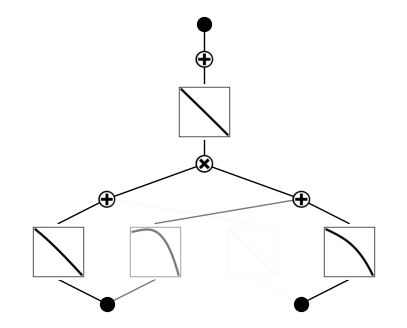

In [44]:
model.plot()

In [45]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

act_fun.0.coef tensor([[[ 5.6939e-04,  2.5393e-03,  1.6347e-03, -1.2068e-03, -1.1418e-04,
           3.4170e-02, -3.4417e-05, -3.2476e-05],
         [-1.1293e-04,  3.4233e-03, -7.3519e-04, -9.0660e-04, -1.9313e-04,
           5.9119e-02,  1.1446e-01, -6.0947e-04]],

        [[ 1.0559e-04,  1.6110e-03, -2.1293e-03,  9.0817e-05,  2.2824e-05,
           1.5920e-05,  9.2316e-05,  4.8331e-04],
         [-1.4326e-03, -5.5596e-04, -1.6931e-03,  3.0028e-04, -4.4244e-04,
           7.2981e-02,  1.4132e-01, -3.5366e-04]]], device='cuda:0')
act_fun.0.scale_base tensor([[-0.3606, -0.0436],
        [-0.0034, -0.1377]], device='cuda:0')
act_fun.0.scale_sp tensor([[0.2542, 0.2551],
        [0.0211, 0.3764]], device='cuda:0')
act_fun.1.coef tensor([[[ 3.1180e-05, -4.1853e-03,  2.4057e-01,  5.0765e-01,  3.1301e-01,
           2.7166e-01,  5.4807e-04, -8.8915e-04]]], device='cuda:0')
act_fun.1.scale_base tensor([[-0.0823]], device='cuda:0')
act_fun.1.scale_sp tensor([[1.4019]], device='cuda:0')
symbolic

saving model version 0.1


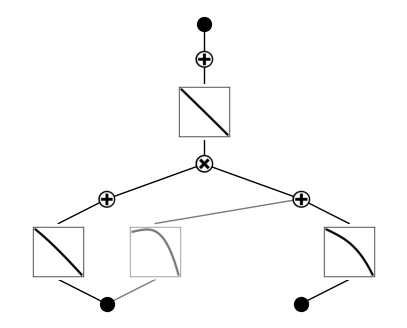

In [46]:
model = model.prune()
model.plot()

fixing (0,0,0) with x^2, r2=0.9999828934669495, c=2
fixing (0,0,1) with exp, r2=0.9896756410598755, c=2
fixing (0,1,0) with 0
fixing (0,1,1) with exp, r2=0.9999069571495056, c=2
fixing (1,0,0) with exp, r2=1.0000004768371582, c=2
saving model version 0.2


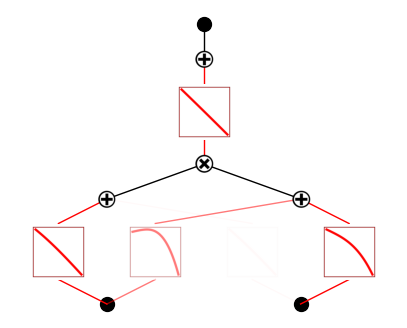

In [47]:
lib = ['1/x', 'x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin', 'abs']
model.auto_symbolic(lib=lib)
model.plot()

In [48]:
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

0.7367 - 0.1704*exp(2.668*(0.0863 - 0.0011*(-9.1526*x_1 - 8.7832)**2)*(-0.0013*exp(3.5558*x_2) - 0.0169))

# **Dataset** $y = x_0 + 0 *x_1$

In [33]:
end_range = 1.0
start_range = -1.0
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range

y = x[:, 0] + 0 * x[:, 1]

dataset = {
    'train_input': x[:1000],
    'train_label': y[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    'test_label': y[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [34]:
model = KAN(width=[2, 1], grid=5, k=3, seed=42, symbolic_enabled=False, device=device)

checkpoint directory created: ./model
saving model version 0.0


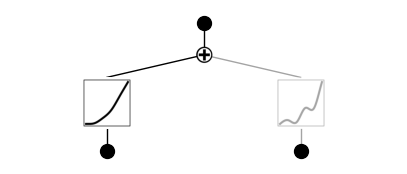

In [35]:
model(dataset['train_input'])
model.plot()

In [36]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

batch_size = 512 # dataset['train_input'].shape[0]
epochs = 600

for epoch in range(epochs):
    batches = dataset['train_input'].shape[0] // batch_size
    for batch_idx in range(batches):
        if batch_idx == batches - 1:
            indices = torch.arange(batch_idx * batch_size, dataset['train_input'].shape[0])
        else:
            indices = torch.arange(batch_idx * batch_size, (batch_idx + 1) * batch_size)
    
        batch_x = dataset['train_input'][indices]
        batch_y = dataset['train_label'][indices]
        
        outputs = model(batch_x)
        
        train_loss = criterion(outputs, batch_y)
        
        # reg = 0.0
        lamb = 0.0001
        l1_reg = sum(torch.norm(p, 1) for p in model.parameters())
        loss = train_loss + lamb * l1_reg
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        test_outputs = model(dataset['test_input'])
        test_loss = criterion(test_outputs, dataset['test_label'])
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, reg: {l1_reg:.4f}')

Epoch [10/600], Train Loss: 0.1158, Test Loss: 0.0976, reg: 36.2013
Epoch [20/600], Train Loss: 0.0571, Test Loss: 0.0460, reg: 37.4382
Epoch [30/600], Train Loss: 0.0212, Test Loss: 0.0167, reg: 38.1821
Epoch [40/600], Train Loss: 0.0078, Test Loss: 0.0067, reg: 39.0167
Epoch [50/600], Train Loss: 0.0045, Test Loss: 0.0041, reg: 39.4998
Epoch [60/600], Train Loss: 0.0022, Test Loss: 0.0019, reg: 39.6295
Epoch [70/600], Train Loss: 0.0012, Test Loss: 0.0010, reg: 39.6495
Epoch [80/600], Train Loss: 0.0009, Test Loss: 0.0008, reg: 39.6547
Epoch [90/600], Train Loss: 0.0007, Test Loss: 0.0006, reg: 39.6657
Epoch [100/600], Train Loss: 0.0005, Test Loss: 0.0005, reg: 39.6881
Epoch [110/600], Train Loss: 0.0004, Test Loss: 0.0004, reg: 39.7031
Epoch [120/600], Train Loss: 0.0003, Test Loss: 0.0003, reg: 39.7036
Epoch [130/600], Train Loss: 0.0003, Test Loss: 0.0002, reg: 39.7055
Epoch [140/600], Train Loss: 0.0002, Test Loss: 0.0002, reg: 39.7114
Epoch [150/600], Train Loss: 0.0001, Test L

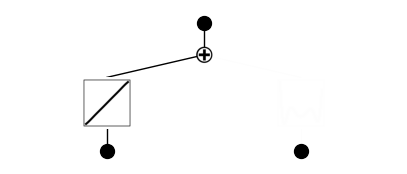

In [37]:
model.plot()

In [29]:
print(dataset["train_input"][:1])
print(model(dataset["train_input"][:1]))

tensor([[ 0.4822, -0.1412]], device='cuda:0')
tensor([[0.4791]], device='cuda:0', grad_fn=<AddBackward0>)


/media/neuron/Data/Projects/Kamchatka/NexusAriadne/nexuskan/MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/media/neuron/Data/Projects/Kamchatka/NexusAriadne/nexuskan/MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  input_range = torch.std(preacts, dim=0) + 0.1
/media/neuron/Data/Projects/Kamchatka/NexusAriadne/nexuskan/MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cp

In [30]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

act_fun.0.coef tensor([[[-7.0632e-01, -5.7213e-01, -2.4203e-01, -1.1024e-02,  1.8615e-01,
           3.0051e-01,  4.1110e-01,  2.6315e-01]],

        [[-1.1514e-03, -1.5552e-01, -1.2937e-01, -1.3376e-01, -1.2705e-01,
          -1.1463e-01, -1.2203e-01, -4.6705e-04]]], device='cuda:0')
act_fun.0.scale_base tensor([[ 0.8860],
        [-0.0221]], device='cuda:0')
act_fun.0.scale_sp tensor([[1.1918],
        [0.7884]], device='cuda:0')
symbolic_fun.0.affine tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.]]], device='cuda:0')


In [38]:
# model(dataset["train_input"])
lib = ['x']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.9999719858169556, c=1
fixing (0,1,0) with x, r2=0.005744590424001217, c=1
saving model version 0.1


In [39]:
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

0.9996*x_1 - 0.0002*x_2 + 0.0004

# **Dataset** $y = x_0 x_1$ and nexusKAN multiplicaton (prod only 11.02.26)

In [40]:
end_range = 1.0
start_range = -1.0
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range
# y = torch.sin(2 * torch.pi * x[:, 0]) + torch.sin(2 * torch.pi * x[:, 1])
# y = x[:, 0] + torch.sin(2 * torch.pi * x[:, 1])
y = x[:, 0] * -x[:, 1]
# y_class = torch.where(y > 0.5, 1.0, 0.0)
dataset = {
    'train_input': x[:1000],
    # 'train_label': y[:1000],
    'train_label': y[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    # 'test_label': y[-200:],
    'test_label': y[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [41]:
model = nexusKAN(width=[2, 1], grid=5, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


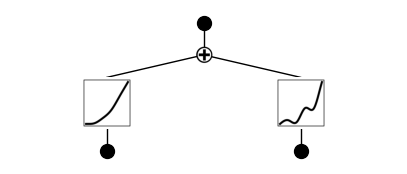

In [42]:
model(dataset['train_input'])
model.plot()

In [43]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

batch_size = 512 # dataset['train_input'].shape[0]
epochs = 600

for epoch in range(epochs):
    batches = dataset['train_input'].shape[0] // batch_size
    for batch_idx in range(batches):
        if batch_idx == batches - 1:
            indices = torch.arange(batch_idx * batch_size, dataset['train_input'].shape[0])
        else:
            indices = torch.arange(batch_idx * batch_size, (batch_idx + 1) * batch_size)
    
        batch_x = dataset['train_input'][indices]
        batch_y = dataset['train_label'][indices]
        
        outputs = model(batch_x)
        
        train_loss = criterion(outputs, batch_y)
        
        # reg = 0.0
        lamb = 0.0001
        l1_reg = sum(torch.norm(p, 1) for p in model.parameters())
        loss = train_loss + lamb * l1_reg
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        test_outputs = model(dataset['test_input'])
        test_loss = criterion(test_outputs, dataset['test_label'])
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, reg: {l1_reg:.4f}')

Epoch [10/600], Train Loss: 0.0994, Test Loss: 0.0917, reg: 35.6743
Epoch [20/600], Train Loss: 0.0791, Test Loss: 0.0713, reg: 37.5546
Epoch [30/600], Train Loss: 0.0431, Test Loss: 0.0367, reg: 39.8905
Epoch [40/600], Train Loss: 0.0122, Test Loss: 0.0110, reg: 42.2358
Epoch [50/600], Train Loss: 0.0096, Test Loss: 0.0086, reg: 43.2357
Epoch [60/600], Train Loss: 0.0029, Test Loss: 0.0029, reg: 42.8384
Epoch [70/600], Train Loss: 0.0014, Test Loss: 0.0013, reg: 42.7975
Epoch [80/600], Train Loss: 0.0004, Test Loss: 0.0005, reg: 43.0962
Epoch [90/600], Train Loss: 0.0003, Test Loss: 0.0003, reg: 43.1288
Epoch [100/600], Train Loss: 0.0002, Test Loss: 0.0002, reg: 43.0662
Epoch [110/600], Train Loss: 0.0002, Test Loss: 0.0002, reg: 43.1268
Epoch [120/600], Train Loss: 0.0001, Test Loss: 0.0001, reg: 43.1612
Epoch [130/600], Train Loss: 0.0001, Test Loss: 0.0001, reg: 43.1527
Epoch [140/600], Train Loss: 0.0001, Test Loss: 0.0001, reg: 43.1667
Epoch [150/600], Train Loss: 0.0001, Test L

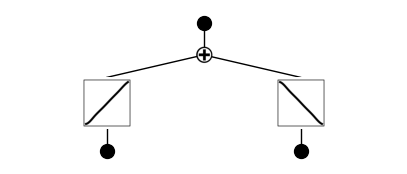

In [44]:
model.plot()

In [8]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

act_fun.0.coef tensor([[[-3.3076e-01, -8.0704e-01, -3.4607e-01, -1.1885e-01,  1.2174e-01,
           2.3345e-01,  3.9661e-01, -2.9590e-04]],

        [[-4.3499e-01, -7.0021e-01, -3.2050e-01, -1.1531e-01,  1.1859e-01,
           2.4442e-01,  4.7225e-01,  2.1484e-03]]], device='cuda:0')
act_fun.0.scale_base tensor([[1.0099],
        [0.5774]], device='cuda:0')
act_fun.0.scale_sp tensor([[1.2124],
        [1.1426]], device='cuda:0')
symbolic_fun.0.affine tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.]]], device='cuda:0')


In [45]:
lib = ['x']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.999772846698761, c=1
fixing (0,1,0) with x, r2=0.9997906684875488, c=1
saving model version 0.1


In [46]:
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

0.9867*x_1 - 1.0133*x_2 + 0.0005

# **Dataset** $y = x_0 + \frac{1}{x_1} + \frac{x_0}{x_1}$ and nexusKAN init interaction (only 17.02.26)

In [74]:
end_range = 2.0
start_range = 0.2
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range
# y = torch.sin(2 * torch.pi * x[:, 0]) + torch.sin(2 * torch.pi * x[:, 1])
# y = x[:, 0] + torch.sin(2 * torch.pi * x[:, 1])
y = x[:, 0] + (1. / x[:, 1]) + x[:, 0] / x[:, 1]
# y_class = torch.where(y > 0.5, 1.0, 0.0)
dataset = {
    'train_input': x[:1000],
    # 'train_label': y[:1000],
    'train_label': y[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    # 'test_label': y[-200:],
    'test_label': y[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

checkpoint directory created: ./model
saving model version 0.0


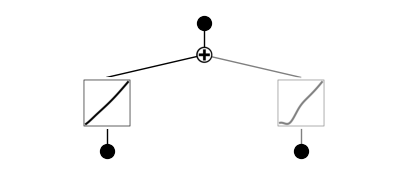

In [75]:
model = nexusKAN(width=[2, 1], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [76]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

batch_size = 512 # dataset['train_input'].shape[0]
epochs = 600

for epoch in range(epochs):
    batches = dataset['train_input'].shape[0] // batch_size
    for batch_idx in range(batches):
        if batch_idx == batches - 1:
            indices = torch.arange(batch_idx * batch_size, dataset['train_input'].shape[0])
        else:
            indices = torch.arange(batch_idx * batch_size, (batch_idx + 1) * batch_size)
    
        batch_x = dataset['train_input'][indices]
        batch_y = dataset['train_label'][indices]
        
        outputs = model(batch_x)
        
        train_loss = criterion(outputs, batch_y)
        
        # reg = 0.0
        lamb = 0.0001
        l1_reg = sum(torch.norm(p, 1) for p in model.parameters())
        loss = train_loss + lamb * l1_reg
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        test_outputs = model(dataset['test_input'])
        test_loss = criterion(test_outputs, dataset['test_label'])
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, reg: {l1_reg:.4f}')

Epoch [10/600], Train Loss: 3.7134, Test Loss: 2.1065, reg: 44.5874
Epoch [20/600], Train Loss: 1.4204, Test Loss: 1.2864, reg: 44.3858
Epoch [30/600], Train Loss: 0.2657, Test Loss: 0.2031, reg: 45.1947
Epoch [40/600], Train Loss: 0.2262, Test Loss: 0.1616, reg: 45.9792
Epoch [50/600], Train Loss: 0.1166, Test Loss: 0.0986, reg: 46.2411
Epoch [60/600], Train Loss: 0.0822, Test Loss: 0.0635, reg: 46.6128
Epoch [70/600], Train Loss: 0.0752, Test Loss: 0.0596, reg: 46.8981
Epoch [80/600], Train Loss: 0.0647, Test Loss: 0.0507, reg: 46.9178
Epoch [90/600], Train Loss: 0.0590, Test Loss: 0.0462, reg: 47.1327
Epoch [100/600], Train Loss: 0.0555, Test Loss: 0.0434, reg: 47.2033
Epoch [110/600], Train Loss: 0.0523, Test Loss: 0.0412, reg: 47.3790
Epoch [120/600], Train Loss: 0.0490, Test Loss: 0.0388, reg: 47.4000
Epoch [130/600], Train Loss: 0.0457, Test Loss: 0.0362, reg: 47.5510
Epoch [140/600], Train Loss: 0.0425, Test Loss: 0.0336, reg: 47.5999
Epoch [150/600], Train Loss: 0.0394, Test L

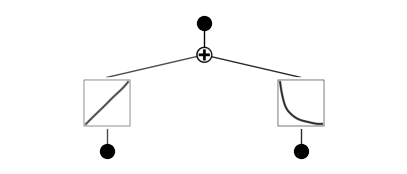

In [77]:
model.plot()

In [78]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

act_fun.0.coef tensor([[[-8.8107e-03, -1.0622e-02,  5.5669e-03, -2.6686e-04,  3.4269e-01,
           4.7555e-01,  4.0654e-01,  3.1569e-01]],

        [[ 1.0968e-02, -2.0248e-02, -1.0081e-02,  7.6069e+00,  1.3256e+00,
           6.5128e-01,  2.9685e-01,  1.6922e-01]]], device='cuda:0')
act_fun.0.scale_base tensor([[1.3657],
        [0.2136]], device='cuda:0')
act_fun.0.scale_sp tensor([[0.6009],
        [1.8835]], device='cuda:0')
act_fun.0.interact_w tensor([0.9655], device='cuda:0')
symbolic_fun.0.affine tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.]]], device='cuda:0')


# **Dataset** $y = 2\sin{2 \pi x_0 + 3.0}$ and nexusKAN $a, b, c, d$

In [38]:
end_range = 1.0
start_range = 0.2
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range
# y = torch.sin(2 * torch.pi * x[:, 0]) + torch.sin(2 * torch.pi * x[:, 1])
# y = x[:, 0] + torch.sin(2 * torch.pi * x[:, 1])
y = 2 * torch.sin(2 * torch.pi * x[:, 0]) + 3.0 * torch.pi # + 2 * torch.sin(2 * torch.pi* x[:, 1] + 3.0)
# y_class = torch.where(y > 0.5, 1.0, 0.0)
dataset = {
    'train_input': x[:1000],
    # 'train_label': y[:1000],
    'train_label': y[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    # 'test_label': y[-200:],
    'test_label': y[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

checkpoint directory created: ./model
saving model version 0.0


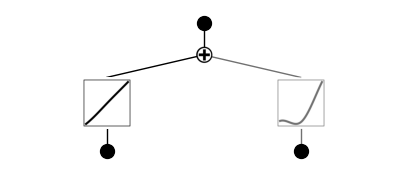

In [39]:
model = nexusKAN(width=[2, 1], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [40]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

batch_size = 512 # dataset['train_input'].shape[0]
epochs = 1000

for epoch in range(epochs):
    batches = dataset['train_input'].shape[0] // batch_size
    for batch_idx in range(batches):
        if batch_idx == batches - 1:
            indices = torch.arange(batch_idx * batch_size, dataset['train_input'].shape[0])
        else:
            indices = torch.arange(batch_idx * batch_size, (batch_idx + 1) * batch_size)
    
        batch_x = dataset['train_input'][indices]
        batch_y = dataset['train_label'][indices]
        
        outputs = model(batch_x)
        
        train_loss = criterion(outputs, batch_y)
        
        # reg = 0.0
        lamb = 0.01
        l1_reg = sum(torch.norm(p, 1) for p in model.parameters())
        loss = train_loss + lamb * l1_reg
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        test_outputs = model(dataset['test_input'])
        test_loss = criterion(test_outputs, dataset['test_label'])
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, reg: {l1_reg:.4f}')

Epoch [10/1000], Train Loss: 18.8037, Test Loss: 11.5355, reg: 50.3223
Epoch [20/1000], Train Loss: 5.1039, Test Loss: 2.7929, reg: 56.5982
Epoch [30/1000], Train Loss: 3.6474, Test Loss: 2.7786, reg: 54.0206
Epoch [40/1000], Train Loss: 1.5738, Test Loss: 1.3180, reg: 56.6643
Epoch [50/1000], Train Loss: 0.7633, Test Loss: 0.5958, reg: 55.3637
Epoch [60/1000], Train Loss: 0.3792, Test Loss: 0.3366, reg: 56.5276
Epoch [70/1000], Train Loss: 0.2205, Test Loss: 0.1759, reg: 56.2266
Epoch [80/1000], Train Loss: 0.1504, Test Loss: 0.1287, reg: 56.5415
Epoch [90/1000], Train Loss: 0.1156, Test Loss: 0.0983, reg: 56.3350
Epoch [100/1000], Train Loss: 0.0948, Test Loss: 0.0865, reg: 56.2548
Epoch [110/1000], Train Loss: 0.0831, Test Loss: 0.0780, reg: 56.1697
Epoch [120/1000], Train Loss: 0.0732, Test Loss: 0.0692, reg: 55.9532
Epoch [130/1000], Train Loss: 0.0642, Test Loss: 0.0618, reg: 55.8442
Epoch [140/1000], Train Loss: 0.0561, Test Loss: 0.0540, reg: 55.6074
Epoch [150/1000], Train Los

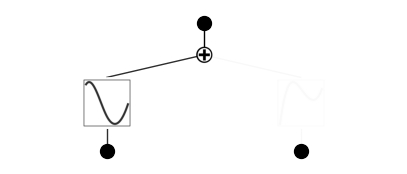

In [41]:
model.plot()

In [42]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

act_fun.0.coef tensor([[[ 3.2300e-05, -1.0627e-02,  5.5701e-03, -4.1566e-04,  2.2977e+00,
           6.9016e-01,  6.2944e-01,  2.0881e+00]],

        [[ 3.3691e-03, -2.0254e-02, -1.0087e-02,  6.9476e-03,  3.9735e-01,
           2.1760e-01, -1.9244e-03, -7.6823e-04]]], device='cuda:0')
act_fun.0.scale_base tensor([[1.8046],
        [0.5417]], device='cuda:0')
act_fun.0.scale_sp tensor([[2.3890],
        [1.0521]], device='cuda:0')
act_fun.0.sum_w tensor([[2.5887],
        [1.2543]], device='cuda:0')
act_fun.0.interact_w tensor([-0.0234], device='cuda:0')
symbolic_fun.0.affine tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.]]], device='cuda:0')


In [43]:
lib = ['sin', 'x']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with sin, r2=0.9990208148956299, c=2
fixing (0,1,0) with x, r2=0.0024174742866307497, c=1
saving model version 0.1


-0.0027*x_2 - 0.777*sin(6.1352*x_1 + 3.2486) + 3.8738